Python実践データ分析100本ノック（秀和システム）の勉強記録を載せています。<br>
問題の解説、コードを載せています。参考になれば幸いです。<br>
わからない点等ございましたらコメントお願いします。¶

# 第8章 数値シミュレーションで消費者行動を予測する10本ノック

会社の商品の売れ行きの予測を行う。<br>
どうやらこの商品はSNSによる口コミで広がっているらしい。<br>
SNSの繋がりから売れ行きの予測はできないか？

* ### データ一覧

| No. | ファイル名 | 概要 |
| :-- | :-- | :-- |
| 1 | links.csv | リピーター20人のSNSでのつながり |
| 2 | links_members.csv | リピーター540人のSNSでのつながり | 
| 3 | info_members.csv | リピーター540人の月々の利用状況 |

# ノック71 : 人間関係のネットワークを可視化する

In [1]:
import pandas as pd

df_links = pd.read_csv('../input/customer-connection/links.csv', index_col='Node')
df_links.head()

,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7,Node8,Node9,Node10,Node11,Node12,Node13,Node14,Node15,Node16,Node17,Node18,Node19
Node,,,,,,,,,,,,,,,,,,,,
Node0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Node1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0
Node2,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
Node3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
Node4,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0


繋がっていれば1、繋がっていなければ０として表現している。networkxを用いて可視化してみる。

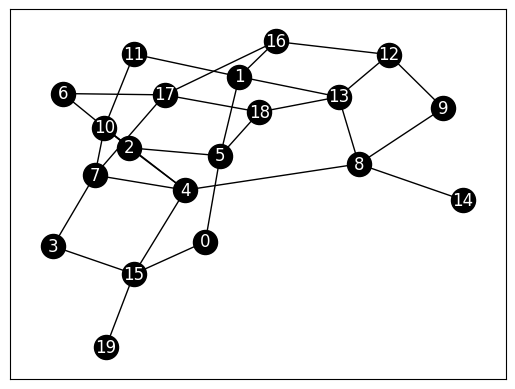

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
NUM = len(df_links.index)
for i in range(NUM):
    # 列名「Node（数字）」から文字列Nodeを取り去る
    node_no = df_links.columns[i].strip('Node')
    # 数字だけ取り出してノードとして追加
    G.add_node(str(node_no))
    
# 辺の設定
for i in range(NUM):
    for j in range(NUM):
        node_name = 'Node' + str(j)
        if df_links[node_name].iloc[i] == 1:
            G.add_edge(str(i), str(j))

# 描画
nx.draw_networkx(G, node_color='k', edge_color='k', font_color='w')
plt.show()

# ノック72 : 口コミによる情報伝播の様子を可視化してみる

### ノック71で読み込んだネットワーク構造を使用する。「１０のつながりのうち、1つの確率（10%）で口コミが伝播していく」と仮定する。

In [3]:
import numpy as np

# 確率的に口コミを伝播させるか決定する
# percent : 伝播確率
def determine_link(percent):
    rand_val = np.random.rand()
    if rand_val <= percent:
        return 1
    else:
        return 0

In [4]:
# 口コミをシミュレーションする
# num : 人数、 list_active : それぞれのノードに口コミが伝わったか表すリスト
# percent_percolation : 口コミの起こる確率

def simulate_percolation(num, list_active, percent_percolation):
    for i in range(num):
        if list_active[i]==1:
            for j in range(num):
                node_name = "Node" + str(j)
                if df_links[node_name].iloc[i]==1:
                    if determine_link(percent_percolation)==1:
                        list_active[j] = 1
    return list_active

In [5]:
percent_percolation = 0.1
# 36ステップ繰り返す。今回は一ヶ月に一回伝播が起こるとして、36ヶ月ととらえる。
T_NUM = 36
NUM = len(df_links.index)
list_active = np.zeros(NUM)
# 最初に口コミを伝播する人
list_active[0] = 1

list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_percolation(NUM, list_active, percent_percolation)
    list_timeSeries.append(list_active.copy())

In [6]:
# アクティブノード可視化
def active_node_coloring(list_active):
    # print(list_timeSeries[t])
    list_color = []
    for i in range(len(list_timeSeries[t])):
        if list_timeSeries[t][i] == 1:
            list_color.append('r')
        else:
            list_color.append('k')
    # print(len(list_color))
    return list_color

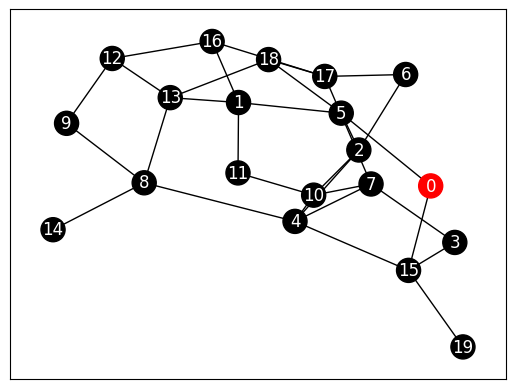

In [7]:
t = 0
nx.draw_networkx(G, font_color='w', node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

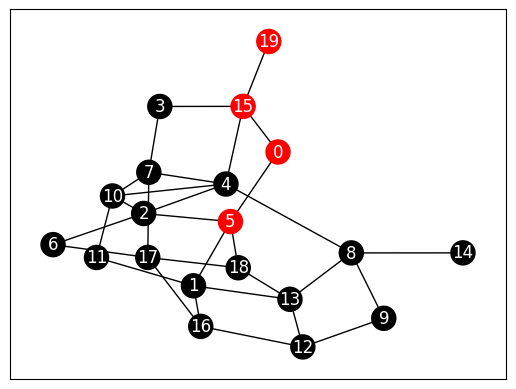

In [8]:
t = 11
nx.draw_networkx(G, font_color='w', node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

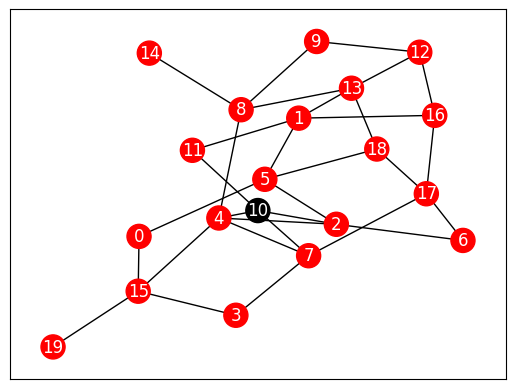

In [9]:
t = 35
nx.draw_networkx(G, font_color='w', node_color=active_node_coloring(list_timeSeries[t]))
plt.show()

図の動画化とかもしてみたかったけど複雑そうなのでやめた。（毎回グラフの形が変わるのをどうかしなきゃいけないのが一つとnotebook環境で動画を配置するのは無理そう？なきがしたため）

# ノック73 : 口コミ数の時系列変化のグラフ化

実際のネットワークの可視化はやや煩雑。口コミ数（伝播した人数の推移）を時系列で表現するだけでも全体像がある程度掴めるはず。

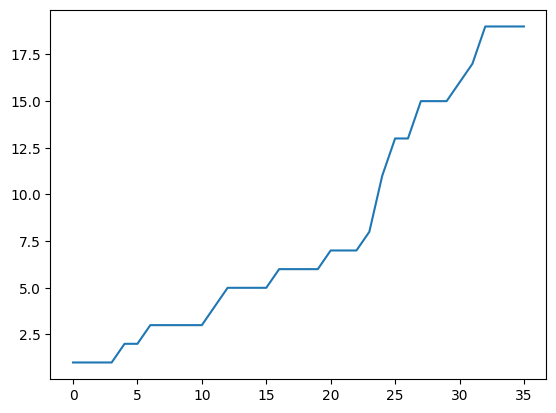

In [10]:
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))

plt.plot(list_timeSeries_num)
plt.show()

# ノック74 : 会員数の時系列変化をシミュレーションする

#### ここからは口コミによって起こる「スポーツジムの利用状況の変化」をシミュレーションする。消費者の行動分析は消費行動であれば一般的に広く用いることができる手法。

In [11]:
def simulate_population(num, list_active, percent_percolation, percent_disapparence,df_links):
    # 拡散 #
    for i in range(num):
        if list_active[i]==1:
            for j in range(num):
                node_name = "Node" + str(j)
                if df_links[node_name].iloc[i]==1:
                    if determine_link(percent_percolation)==1:
                        list_active[j] = 1
    # 消滅 #
    for i in range(num):
        if determine_link(percent_disapparence)==1:
            list_active[i] = 0
    return list_active
                        

In [12]:
percent_percolation = 0.1
percent_disapparence = 0.05
T_NUM = 100
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1

list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence, df_links)
    list_timeSeries.append(list_active.copy())

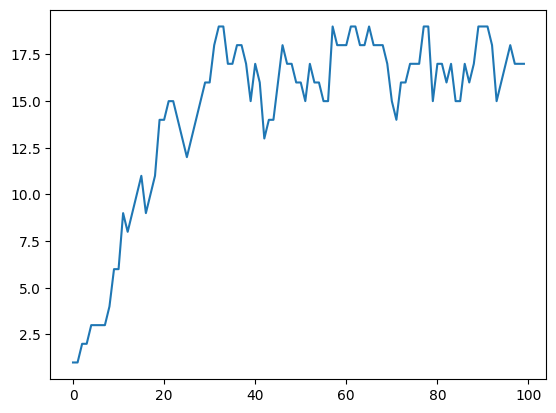

In [13]:
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    # 会員数を各月毎に足し合わせる
    list_timeSeries_num.append(sum(list_timeSeries[i]))

plt.plot(list_timeSeries_num)
plt.show()

#### 会員はある日突然辞める可能性がある。これを5%とおいてみると、集団の力で入会率は100%に近づくことがわかる。

* ### 退会率（ある日突然辞める確率）を20%にしてみると...

In [14]:
percent_percolation = 0.1
percent_disapparence = 0.2 # 突然辞める確率を変化させた
T_NUM = 100
NUM = len(df_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1

list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence, df_links)
    list_timeSeries.append(list_active.copy())

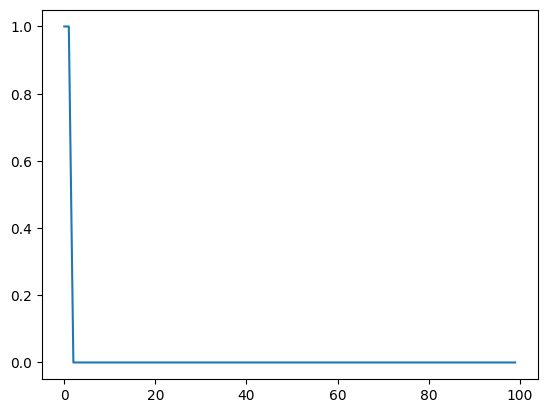

In [15]:
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    # 会員数を各月毎に足し合わせる
    list_timeSeries_num.append(sum(list_timeSeries[i]))

plt.plot(list_timeSeries_num)
plt.show()

（確率的変動をするので）回にもよるが、おおよそ入会率は0%に近づいていく。

# ノック75 : パラメータの全体像を「相図」で把握する

* ### 実行に時間がかかるので注意！

In [16]:
# 相図計算
print("相図計算開始")
T_NUM = 100
NUM_PhaseDiagram = 20
phaseDiagram = np.zeros((NUM_PhaseDiagram,NUM_PhaseDiagram))
for i_p in range(NUM_PhaseDiagram):
    for i_d in range(NUM_PhaseDiagram):
        percent_percolation = 0.05*i_p
        percent_disapparence = 0.05*i_d
        list_active = np.zeros(NUM)
        list_active[0] = 1
        for t in range(T_NUM):
            list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence,df_links)
        phaseDiagram[i_p][i_d] = sum(list_active)
print(phaseDiagram)

相図計算開始
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 15.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 17. 15.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 18. 15. 16.  6. 12.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20.  0. 14.  0.  8.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 19. 17. 14. 12.  7.  9.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 18.  0. 13. 12.  8.  0. 12.  7.  9.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 18. 18. 15.  0. 13. 13. 10. 11.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 17. 19. 17. 17. 13. 12.  9. 11.  6.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 20. 18.  0. 14. 15.  0. 11. 11. 10.  6.  8.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [20. 19. 19. 14. 16.  0.  0. 12. 10.  7.  8.  0.  0.  0. 

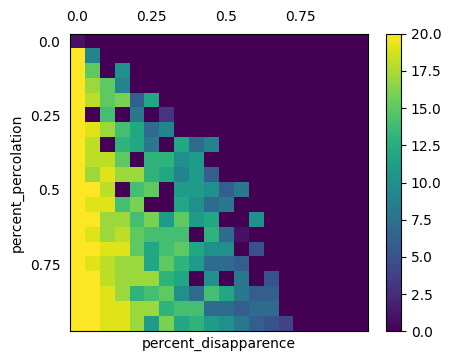

In [17]:
plt.matshow(phaseDiagram)
plt.colorbar(shrink=0.8)
plt.xlabel('percent_disapparence')
plt.ylabel('percent_percolation')
plt.xticks(np.arange(0.0, 20.0, 5), np.arange(0.0, 1.0, 0.25))
plt.yticks(np.arange(0.0, 20.0, 5), np.arange(0.0, 1.0, 0.25))
plt.tick_params(bottom=False,
                left=False,
                right=False,
                top=False)
plt.show()


自然に退会する確率が20%~30%を超えるとどんなに口コミの伝播確率が高くても利用者が増えない。

# ノック76 : 実データを読み込む

In [18]:
df_mem_links = pd.read_csv('../input/customer-connection/links_members.csv', index_col='Node')
df_mem_info = pd.read_csv('../input/customer-connection/info_members.csv', index_col='Node')
df_mem_links.head()

,Node0,Node1,Node2,Node3,Node4,Node5,Node6,Node7,Node8,Node9,...,Node530,Node531,Node532,Node533,Node534,Node535,Node536,Node537,Node538,Node539
Node,,,,,,,,,,,,,,,,,,,,,
Node0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Node1,0,0,0,0,1,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
Node2,1,0,0,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,1,1,0
Node3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Node4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0


# ノック77 : リンク数の分布の可視化

ネットワーク構造が「スモールワールド型」なのか「スケールフリー」型なのかそれ以外なのかを把握するのにリンク数の分布の可視化が有効。

In [19]:
NUM = len(df_mem_links.index)
array_linkNum = np.zeros(NUM)
for i in range(NUM):
    array_linkNum[i] = sum(df_mem_links['Node' + str(i)])

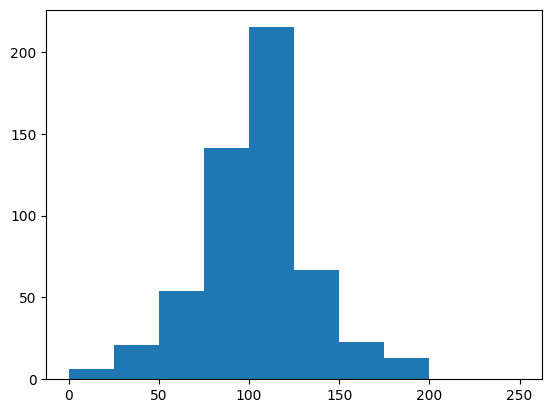

In [20]:
plt.hist(array_linkNum, bins=10, range=(0, 250))
plt.show()

#### 大体全部のノードが100程度のつながりを持つ。<br>→特定のノードに頼らずとも情報が伝播していくことを示唆

# ノック78 : シミュレーションのために実データからパラメータを推定する

### ここでいう「パラメータ」は「消滅確率」と「拡散確率」のこと

* ### この二つのコードすごく重いので注意

In [21]:
NUM = len(df_mem_info.index)
T_NUM = len(df_mem_info.columns)-1
# 消滅の確率推定 #
count_active = 0
count_active_to_inactive = 0
for t in range(T_NUM):
    for i in range(NUM):
        if (df_mem_info.iloc[i, t]==1):
            count_active_to_inactive += 1
            if (df_mem_info.iloc[i, t+1]==0):
                count_active += 1
estimated_percent_disapparence = count_active/count_active_to_inactive

In [22]:
# 拡散の確率推定 #
count_link = 0
count_link_to_active = 0
count_link_temp = 0
for t in range(T_NUM):
    df_link_t = df_mem_info[df_mem_info[str(t)]==1]
    temp_flag_count = np.zeros(NUM)
    for i in range(len(df_link_t.index)):
        index_i = int(df_link_t.index[i].replace("Node",""))
        df_link_temp = df_mem_links[df_mem_links["Node"+str(index_i)]==1]
        for j in range(len(df_link_temp.index)):
            index_j = int(df_link_temp.index[j].replace("Node",""))
            if (df_mem_info.iloc[index_j, t]==0):
                if (temp_flag_count[index_j]==0):
                    count_link += 1
                if (df_mem_info.iloc[index_j, t+1]==1):
                    if (temp_flag_count[index_j]==0):
                        temp_flag_count[index_j] = 1 
                        count_link_to_active += 1
estimated_percent_percolation = count_link_to_active/count_link

In [23]:
estimated_percent_disapparence

0.10147163541419416

In [24]:
estimated_percent_percolation

0.039006364196263604

# ノック79 : 実データとシミュレーションを比較する

* ### 一個目のコード実行に30分かかるので実行時は注意！！

In [25]:
percent_percolation = 0.039006364196263604
percent_disapparence = 0.10147163541419416
T_NUM = 24
NUM = len(df_mem_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1
list_timeSeries = []
for t in range(T_NUM):
  list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence,df_mem_links)
  list_timeSeries.append(list_active.copy())

In [26]:
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))

In [27]:
T_NUM = len(df_mem_info.columns)-1
list_timeSeries_num_real = []
for t in range(0,T_NUM):
    list_timeSeries_num_real.append(len(df_mem_info[df_mem_info[str(t)]==1].index))

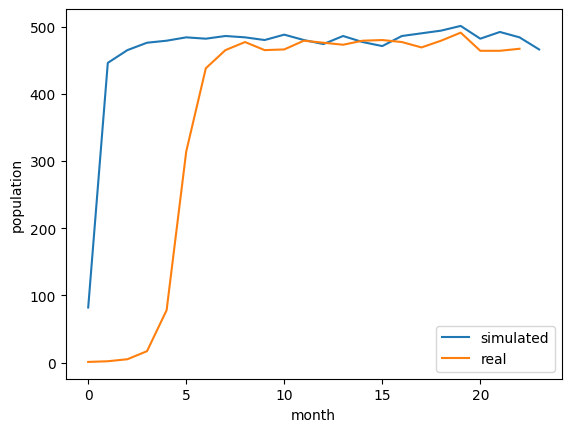

In [28]:
plt.plot(list_timeSeries_num, label = 'simulated')
plt.plot(list_timeSeries_num_real, label = 'real')
plt.xlabel('month')
plt.ylabel('population')
plt.legend(loc='lower right')
plt.show()

# ノック80 : シミュレーションによる将来予測の実施

In [29]:
percent_percolation = 0.039006364196263604
percent_disapparence = 0.10147163541419416
T_NUM = 36
NUM = len(df_mem_links.index)
list_active = np.zeros(NUM)
list_active[0] = 1
list_timeSeries = []
for t in range(T_NUM):
    list_active = simulate_population(NUM, list_active, percent_percolation, percent_disapparence,df_mem_links)
    list_timeSeries.append(list_active.copy())

In [30]:
list_timeSeries_num = []
for i in range(len(list_timeSeries)):
    list_timeSeries_num.append(sum(list_timeSeries[i]))

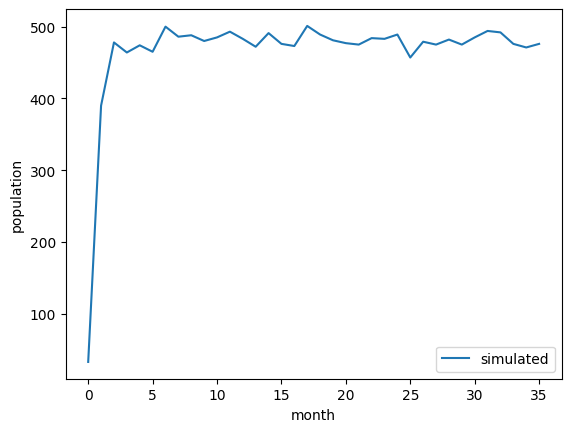

In [31]:
plt.plot(list_timeSeries_num, label = 'simulated')
plt.xlabel('month')
plt.ylabel('population')
plt.legend(loc='lower right')
plt.show()